# 用户数据处理

用户描述信息在u.user文件：共7维特征
user id
age：年龄
gender：性别
occupation：职业
zip code：地点

this is a tab separated list of
user id | age | gender | occupation | zip code
The user ids are the ones used in the u.data data set.

# 导入工具包

In [1]:
import pandas as pd
import numpy as np

import scipy.sparse as ss
import scipy.io as sio

#保存数据
import cPickle

#特征编码
from utils import FeatureEng
#用户数目和电影数目
from utils import n_Users, n_Movies

from sklearn.preprocessing import normalize
#相似度/距离
import scipy.spatial.distance as ssd

# 读入数据

用户数据文件为u.user，文件格式为u.user
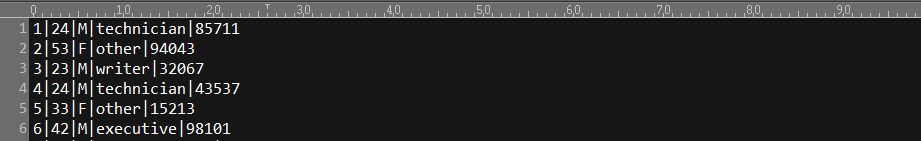

In [2]:
# 读入数据
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='|', names=u_cols,encoding='latin-1')

users.head()

user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
1        2   53   F       other    94043
2        3   23   M      writer    32067
3        4   24   M  technician    43537
4        5   33   F       other    15213

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
user_id       943 non-null int64
age           943 non-null int64
sex           943 non-null object
occupation    943 non-null object
zip_code      943 non-null object
dtypes: int64(2), object(3)
memory usage: 36.9+ KB


In [4]:
FE = FeatureEng()

#n_users = users.shape[0]  #直接在utils文件中设置
# 'age', 'sexID', 'occupationID', 'zip_codeID'

n_cols = users.shape[1] - 1
cols = ['age', 'sexID', 'occupationID', 'zip_codeID']

#users编码后的特征
userMatrix = ss.dok_matrix((n_Users, n_cols))

for u in range(users.shape[0]): 
    userId = users.loc[u,'user_id']-1  #索引从0开始
    
    userMatrix[userId, 0] =users.loc[u,'age']
    userMatrix[userId, 1] = FE.getSexId(users.loc[u,'sex'])
    userMatrix[userId, 2] = FE.getoccupationId(users.loc[u,'occupation'])
    userMatrix[userId, 3] = FE.getzip_codeInt(users.loc[u,'zip_code'])

# 归一化用户矩阵
userMatrix = normalize(userMatrix, norm="l2",  copy=False)
sio.mmwrite("US_userMatrix", userMatrix)

# 计算用户相似度矩阵，之后用户推荐系统
userSimMatrix = ss.dok_matrix((n_Users, n_Users))

#读取在测试集和训练集中出现的事件对
uniqueUserPairs = cPickle.load(open("uniqueUserPairs.pkl", 'rb'))

#对角线元素
for i in range(0, n_Users):
    userSimMatrix[i, i] = 1.0
    
#对称
for u1, u2 in uniqueUserPairs:
    i = u1; #int(u1)-1
    j = u2; #int(u2)-1
    if not userSimMatrix.has_key((i, j)):
        usim = ssd.correlation(userMatrix.getrow(i).todense(),
          userMatrix.getrow(j).todense())
        userSimMatrix[i, j] = usim
        userSimMatrix[j, i] = usim
    
sio.mmwrite("userSimMatrix", userSimMatrix)